# Capstone Project: Battle of the Neighborhoods
## Analysis by Joshua Satre

## 1) Introduction 
### Background:
In the wake of the post-lockdown phase of the Covid-19 pandemic, the restaurant industry requires significant changes to it's core business model that will enable better sanitation and implementation of recommended social distancing for employees and customers. New York City was the the hardest hit by the pandemic and as the city with the highest population density is an ideal test case for technological solutions that will aid the achievement of implementing sanitation and social distancing guidelines while still achieving the goal of quality product and high-volume production of food for takeout, delivery and commercial clients.  The help the restaurant industry needs may come in the form of robotics (made by companies such as Picnic ([1], which can preserve the input quality of ingredients while automating the busywork and reducing the number of physical employees in the kitchen space to enable social distancing and greater sanitation. 


### Client and Business Case/Problem:
This report was performed for a vendor in the food robotics industry in April-May 2020. The goal of this report is to identify neighborhoods ideal for placing a sales office for the client. _However, more generally, the analysis would be useful for any entrepreneurs in the food-service equipment industry seeking to locate their office in an ideal space.  As New York City, specifically Manhattan, is famous for it's pizza, it is an ideal test market for the rollout of the pizza vending robot our client is making. Specifically: the client has asked *"Where in Manhattan should we locate our office to maximize density of potential sales venue?"* 

#### Deliverable:
Specifically, our client wants *a list of target neighborhoods with the a large number of pizza vendors*, so as to have more potential sales targets. 

We can use our data analysis abilities and deploy a range of techniques to generate a list of ideal neighborhoods and then outline the advantages of each neighborhood (and flag potential downsides) which will enable our client to make an informed decision about the placement of their office.  

## 2) Data
Our business case and client question should shape the data we are going to use. In this case, the number of client-relevant restaurants in each neighborhood  (i.e. Italian and Pizza restaurants, but also fast food places serving pizza. Note that Foursquare already flags any restaurant that serves pizza, regardless of the other cuisines.)
 
Several data sources will be used in this analysis. For neighborhood data, NYU's Spatial Data Repository repository contains an excellent open-source map of New York's neighborhoods with geospatial point data (https://geo.nyu.edu/catalog/nyu_2451_34572) which we will use in this analysis.

For locations within each neighborhood, We will be using the Foursquare API to find data on concentrations of restaurants, including pizza places and italian restaurants , as well as other venues and neighborhood characteristics. Foursquare is a technology company that offers software that enables users to upload real-time location and venue data. As a result, we can find up-to-date lists of venues and target specific types of venues using the API.

Finally, In terms of python libraries, there are several used for data gathering in this project:
We will be using the geopy library to get the latitude and longitude values of New York City.
The Folium library will be used for data visualization. Several other packages will be used for our analysis, for more information, see the main text in the Methodology section.

Utilizing data analysis and analytical techniques discussed in the labs from Coursera's IBM Data Science Professional Certificate, the data will be analyzed using the methods outlined below.


## 3) Methodology 

This section outlines (with code) the methods used in our analysis. We will start by importing our required libraries. 


In [3]:
# Import required libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import the library we use to open URLs
import urllib.request


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Next, we can use our newly imported packages to write a function that will grab the json data from any url inputted into the function.

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
#our data contains information as features--we can create a pandas dataframe after isolating it in the features key.
neighborhoods_data = newyork_data['features']
#See below for example of what it looks like
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

Now, we can convert this into a pandas dataframe

In [10]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
#write a for loop that adds in data from our neighborhoods_data above.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
#check the shape of the dataframe
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Geopy map
Let's visualize the neighborhoods we are examining in our search. We  We can use the geopy library to get the latitude and longitude values of Manhattan, NY.  In order to define an instance of the geocoder, we need to define a user_agent. Let's name this ny_explorer.

In [12]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Manhattan are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Manhattan are 40.7896239, -73.9598939.


Now, we can create a map of Manhattan with neighborhoods superimposed on the top.

In [13]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Foursquare
Now we can use Foursquare's API to get the data on pizza restaurants.
For privacy reasons, there is a hidden cell  below containing the API key information.

In [14]:
# @hidden_cell
CLIENT_ID = 'E3Y2MNA2BN2MQLRDOGN3IBABS1Q0NWDPML2AFPJ5MPQUVJKU' # your Foursquare ID
CLIENT_SECRET = 'IEIBCPWTJS0BDJZGZX52Y3ODDOCL2XMWZUSEAINVWZRDCZFG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

We will limit to the first 100 venues and define a search radius of 500.

In [15]:
LIMIT = 100
radius = 500

Now,we create a function that uses category id from Foursquare to get ONLY the pizza places (or client-relevant places that serve pizza, i.e. fast food restaurants, etc.) let's call it getPizzavenues.

In [16]:
def getPizzaVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            "4bf58dd8d48988d1ca941735"
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Next, we create a pandas dataframe called nyc_venues that uses the function we just define to find all the pizza places in manhattan and put them into a pandas dataframe

In [17]:
nyc_venues = getPizzaVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
nyc_venues.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.910660,Pizza Hut Express,40.873201,-73.907861,Pizza Place
2,Marble Hill,40.876551,-73.910660,Kennedy Chicken & Pizza,40.874986,-73.909184,Fast Food Restaurant
3,Chinatown,40.715618,-73.994279,Scarr's Pizza,40.715335,-73.991649,Pizza Place
4,Chinatown,40.715618,-73.994279,Williamsburg Pizza,40.718303,-73.991046,Pizza Place


Using this, let's create a new dataframe summarizing the counts of the above dataframe by borough, briefly checking our table to make sure it makes sense.

In [18]:

summary = nyc_venues.groupby('Neighborhood').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Neighborhood,Count
0,Stuyvesant Town,1
1,Roosevelt Island,2
2,Marble Hill,3
3,Morningside Heights,5
4,Central Harlem,6


Now, we can graphically analyze it using matplotlib

## 4) Analysis

Matplotlib version:  3.1.1


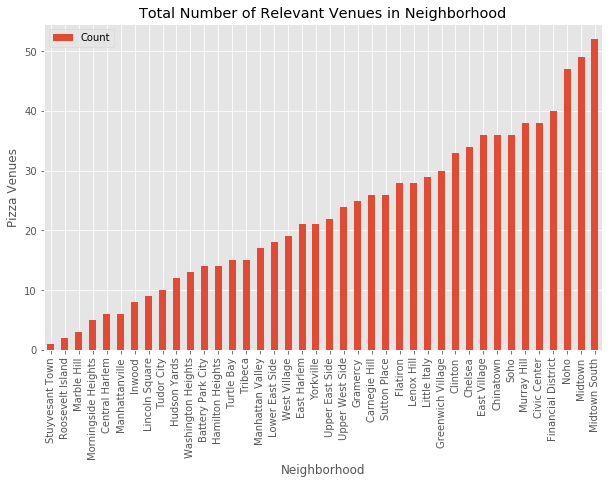

In [31]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
import numpy as np

objects = summary.Neighborhood
y_pos = np.arange(len(objects))
sumcount = summary.count
summary.plot(kind='bar',figsize=(10, 6))
plt.xticks(y_pos,objects)
plt.xlabel('Neighborhood')
plt.ylabel('Pizza Venues')
plt.title('Total Number of Relevant Venues in Neighborhood')
plt.xticks(rotation=90)
plt.show()


In [32]:
## 3. Analyze Each Neighborhood

We can use onehot encoding to create dummy variables for each venue type. While it might seem a bit off to use onehot, as the majority of these will be zeros, this is important because other venue types are included beside pizza place and we don't want to exclude them. The code below encodes  and groups neighborhoods accordingly.

In [33]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Neighborhood,American Restaurant,Bakery,Bar,Beer Garden,Breakfast Spot,Burger Joint,Café,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner,Fast Food Restaurant,Food & Drink Shop,Gay Bar,Gluten-free Restaurant,Gourmet Shop,Grocery Store,Hookah Bar,Hotel Bar,Irish Pub,Italian Restaurant,Jazz Club,Lounge,Mexican Restaurant,New American Restaurant,Pizza Place,Pub,Restaurant,Rock Club,Sandwich Place,Seafood Restaurant,Sports Bar,Sushi Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [34]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

,Neighborhood,American Restaurant,Bakery,Bar,Beer Garden,Breakfast Spot,Burger Joint,Café,Cocktail Bar,Deli / Bodega,Dessert Shop,Diner,Fast Food Restaurant,Food & Drink Shop,Gay Bar,Gluten-free Restaurant,Gourmet Shop,Grocery Store,Hookah Bar,Hotel Bar,Irish Pub,Italian Restaurant,Jazz Club,Lounge,Mexican Restaurant,New American Restaurant,Pizza Place,Pub,Restaurant,Rock Club,Sandwich Place,Seafood Restaurant,Sports Bar,Sushi Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,Battery Park City,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000,0.000000,0.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Carnegie Hill,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000,0.000000,0.807692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.038462
2,Central Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,Chelsea,0.029412,0.058824,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.147059,0.000000,0.000000,0.000,0.000000,0.705882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
4,Chinatown,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.361111,0.000000,0.000000,0.000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.00,0.000000,0.000000
5,Civic Center,0.026316,0.000000,0.052632,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078947,0.000000,0.026316,0.000,0.000000,0.736842,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.00,0.000000,0.000000
6,Clinton,0.030303,0.000000,0.060606,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000,0.030303,0.696970,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
7,East Harlem,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,East Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
9,Financial District,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.025,0.000000,0.800000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.00,0.000000,0.000000


Let's check the top 5 types of venues for each neighborhood in our data. Note that pizza place will likely be the top function in most of these, and our client will want the ones that are highest in frequency (i.e., the densest).

In [35]:
num_top_venues = 5

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                venue  freq
0         Pizza Place  0.64
1  Italian Restaurant  0.14
2        Gourmet Shop  0.14
3        Burger Joint  0.07
4                 Pub  0.00


----Carnegie Hill----
                venue  freq
0         Pizza Place  0.81
1  Italian Restaurant  0.08
2                Café  0.04
3            Wine Bar  0.04
4                 Bar  0.04


----Central Harlem----
                 venue  freq
0          Pizza Place   1.0
1  American Restaurant   0.0
2                  Pub   0.0
3   Italian Restaurant   0.0
4            Jazz Club   0.0


----Chelsea----
                 venue  freq
0          Pizza Place  0.71
1   Italian Restaurant  0.15
2               Bakery  0.06
3        Grocery Store  0.03
4  American Restaurant  0.03


----Chinatown----
                venue  freq
0         Pizza Place  0.50
1  Italian Restaurant  0.36
2              Bakery  0.08
3        Gourmet Shop  0.03
4  Seafood Restaurant  0.03


----Civic Center----
            

While sorting through the above data could yield answers, a function would do this faster and put it into a neat table. let's do this instead.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Pizza Place,Italian Restaurant,Gourmet Shop,Burger Joint,Deli / Bodega
1,Carnegie Hill,Pizza Place,Italian Restaurant,Café,Wine Bar,Bar
2,Central Harlem,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
3,Chelsea,Pizza Place,Italian Restaurant,Bakery,American Restaurant,Bar
4,Chinatown,Pizza Place,Italian Restaurant,Bakery,Seafood Restaurant,Gourmet Shop


In [1]:
## 4. Cluster Neighborhoods

For collecting a set of target neighborhoods, rather than just picking one, we can use a clustering analysis. Using the data above, we can create a graph to determine the ideal k (i.e. number of clusters) at the 'elbow' of the graph and use that to cluster our neighborhoods.

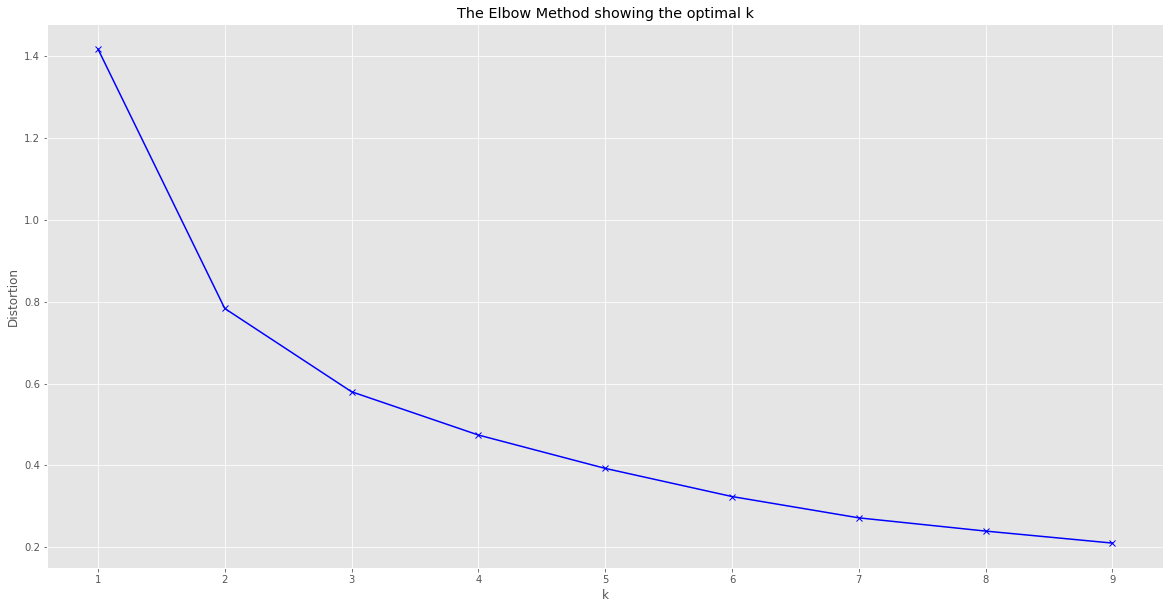

In [39]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(nyc_grouped_clustering)
    distortions.append(kmeanModel.inertia_)
    
#plot distortions using Matplotlib to find the elbow and thus the correct number of K clusters    
import matplotlib.pyplot as plt    
plt.figure(figsize=(20,10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()



In [40]:
# set number of clusters (per the above graph, the elbow appears to be at two or three--let's choose three, as that gives us more clusters)
kclusters = 3

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 2, 1, 0, 1, 1, 2, 2, 1], dtype=int32)

Now that we have our clusters we can merge our data and add clustering lables

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = manhattan_data

# merge nyc_grouped with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Pizza Place,Fast Food Restaurant,Grocery Store,Gluten-free Restaurant,Gay Bar
1,Manhattan,Chinatown,40.715618,-73.994279,0,Pizza Place,Italian Restaurant,Bakery,Seafood Restaurant,Gourmet Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Pizza Place,Restaurant,Cocktail Bar,Gay Bar,Food & Drink Shop
3,Manhattan,Inwood,40.867684,-73.921210,2,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Italian Restaurant,Café,Pub,Deli / Bodega


Let's visualize our clusters and map them onto Manhattan

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
#### Cluster 1 Results

In [43]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Chinatown,Pizza Place,Italian Restaurant,Bakery,Seafood Restaurant,Gourmet Shop
8,Upper East Side,Pizza Place,Italian Restaurant,Diner,American Restaurant,Bakery
10,Lenox Hill,Pizza Place,Italian Restaurant,Café,Diner,Cocktail Bar
13,Lincoln Square,Pizza Place,Italian Restaurant,American Restaurant,Bar,Beer Garden
21,Tribeca,Pizza Place,American Restaurant,Italian Restaurant,Bar,Burger Joint
24,West Village,Pizza Place,Italian Restaurant,Jazz Club,Wine Bar,Bar
27,Gramercy,Pizza Place,Italian Restaurant,Sushi Restaurant,Bar,Sandwich Place
28,Battery Park City,Pizza Place,Italian Restaurant,Gourmet Shop,Burger Joint,Deli / Bodega


In [ ]:
#### Cluster 2 Results

In [44]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Pizza Place,Fast Food Restaurant,Grocery Store,Gluten-free Restaurant,Gay Bar
4,Hamilton Heights,Pizza Place,Italian Restaurant,Café,Pub,Deli / Bodega
5,Manhattanville,Pizza Place,Italian Restaurant,Gourmet Shop,Gay Bar,Food & Drink Shop
9,Yorkville,Pizza Place,Bar,Italian Restaurant,Pub,Deli / Bodega
12,Upper West Side,Pizza Place,Italian Restaurant,Vegetarian / Vegan Restaurant,Bar,Breakfast Spot
14,Clinton,Pizza Place,Italian Restaurant,Bar,Café,Diner
15,Midtown,Pizza Place,Italian Restaurant,Pub,Café,American Restaurant
17,Chelsea,Pizza Place,Italian Restaurant,Bakery,American Restaurant,Bar
18,Greenwich Village,Pizza Place,Italian Restaurant,American Restaurant,Rock Club,Gluten-free Restaurant
22,Little Italy,Pizza Place,Italian Restaurant,Bakery,Bar,Deli / Bodega


In [ ]:
#### Cluster 3 Results

In [45]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Washington Heights,Pizza Place,Restaurant,Cocktail Bar,Gay Bar,Food & Drink Shop
3,Inwood,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
6,Central Harlem,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
7,East Harlem,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
11,Roosevelt Island,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
16,Murray Hill,Pizza Place,Italian Restaurant,Burger Joint,Restaurant,Pub
19,East Village,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
20,Lower East Side,Pizza Place,Bakery,Deli / Bodega,Gluten-free Restaurant,Gay Bar
26,Morningside Heights,Pizza Place,Grocery Store,Gluten-free Restaurant,Gay Bar,Food & Drink Shop
36,Tudor City,Pizza Place,Italian Restaurant,Gourmet Shop,Gay Bar,Food & Drink Shop


Based on these results, we can see that cluster 2 is likely to be the most ideal list from which to draw our potential locations. The list includes the top 3 results from the graph (NoHo, Midtown, Mitown South)--the only neighborhoods which  have more than 40 pizza joints. Additionally, the second most common category is italian restaurants, which are likely to also be sales targets. 
The results from analysis above will be discussed below

## 5) Results & Discussion

As you can see from the above analysis, New York City is a big place, so we focused on Manhattan to have more clear results. There is a high population density, so any of our target neighborhoods are likely to have enough potential customers, and we need only focus on our potential sales venues. The pizza joints appear from the graph to be highly concentrated in several neighborhoods--only three have more than 50 pizza joints:  NoHo, Midtown, and Midtown South. These would appear to be the three most ideal locations for a sales office. 
note that very different approaches can be tried in clustering and classification studies. Moreover, results may differ depending on which method is used

I chose to use the Kmeans algorithm as part of this clustering study. When I tested the data using the  Elbow method, I set the optimum k value to 3. The visualization of the clusters illustrates that they are somewhat scattered. However, Cluster 2 is likelt the best fit. This is particularly true given that Cluster 3 includes as it's second-most category grocery stores--which compete with pizza joints and wouldn't be suitable for targeting our client's products, whereas Cluster 2 contains as it's runner up primarily Italian restaurants, which do fit our client's criteria.

However, only a small subset of the total data from Foursquare was used, owing to the focus on pizza joints. For more detailed and accurate guidance, the data set can be expanded and include a number of other variables, including the relative cost of offices, from places such as Zillow [5]  which owing to data compatibility issues with the NYC geospatial repository data were excluded.

I also performed data analysis through this information by adding only static data--dynamically updating from APIs would likely yield more accurate results on a more frequent basis.

I ended the study by visualizing the data and clusters on the Manhattan map. In future studies, adding additional data would likely yield more informed results. 

## 6) Conclusion

Now that we have explored our data, we can see that NYC has many pizza places. However, the most pizza places are located in three neighborhoods, NoHo, Midtown, and Midtown South. These neighbhorhoods are all excellent targets for the client.
Of course, of these three, the client should pick the one with the lowerest cost, or one from cluster two that is adjacent but lower price.

Thank you for reading this report.


## 7) References

#### 1) [Picnic] (https://www.hellopicnic.com/press)
#### 2) [NYU Geospatial Data Repository - NYC Neighborhoods] (https://geo.nyu.edu/catalog/nyu_2451_34572)
#### [3] [Foursquare API]( https://developer.foursquare.com/docs/places-api/)
#### [4] [Folium] (https://python-visualization.github.io/folium/)
#### [5] [Zillow Housing Data] (https://www.zillow.com/research/data/)
